## Создание сетки и триангуляция области

In [21]:
from itertools import product
from scipy.spatial import Delaunay
import numpy as np
paramDivider = 8
bounds = np.array([[0.01, 0], [0.02, 0], [0.02, 0.01], [0.01, 0.01], [0.01, 0]])
x_list, y_list = np.linspace(bounds[0, 0], bounds[1, 0], paramDivider), np.linspace(bounds[1, 1], bounds[2, 1], paramDivider)
areaPoints_Coords = np.array(list(product(x_list,y_list)))
areaPoints = [x for x in range(len(areaPoints_Coords))]
areaBoundaryPoints = [idx for idx, val in enumerate(areaPoints_Coords) if val[0] in [bounds[0, 0], bounds[1, 0]] or val[1] in [bounds[0, 1], bounds[2, 1]]]

tri = Delaunay(areaPoints_Coords)
dirichlet_conditions = [[0, 1], [1, 0], [3, 0]]
neumann_conditions = [[2, 0, -2e+7]]

dirichletPoints = [[[idx for idx, val in enumerate(areaPoints_Coords) 
                     if min([bounds[cond[0], 0], bounds[cond[0] + 1, 0]]) <= val[0] <= max([bounds[cond[0], 0], bounds[cond[0] + 1, 0]])
                     and min([bounds[cond[0], 1], bounds[cond[0] + 1, 1]]) <= val[1] <= max([bounds[cond[0], 1], bounds[cond[0] + 1, 1]])], cond[1]] for cond in dirichlet_conditions]

neumannPoints = [[[idx for idx, val in enumerate(areaPoints_Coords) 
                     if min([bounds[cond[0], 0], bounds[cond[0] + 1, 0]]) <= val[0] <= max([bounds[cond[0], 0], bounds[cond[0] + 1, 0]])
                     and min([bounds[cond[0], 1], bounds[cond[0] + 1, 1]]) <= val[1] <= max([bounds[cond[0], 1], bounds[cond[0] + 1, 1]])], cond[1], cond[2]] for cond in neumann_conditions]

dirichletPointsAll = sorted(list(set(sum([side[0] for side in dirichletPoints], []))))
neumannPointsAll = sorted(list(set(sum([side[0] for side in neumannPoints], []))))

## Построение сетки

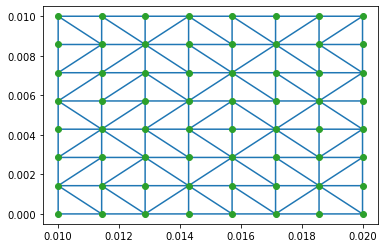

In [22]:
import matplotlib.pyplot as plt
plt.triplot(areaPoints_Coords[:,0], areaPoints_Coords[:,1], tri.simplices.copy())
plt.plot(areaPoints_Coords[:,0], areaPoints_Coords[:,1], 'o')
plt.show()

## Создание файла с данными

In [23]:
#Коэффициенты для задачи
dimTask = 2
amntSubdomains = [2, 1]
coefOverlap = 0.3
E = 70e+9
nyu = 0.34
coef_u = 1000
coef_sigma = 1e-6

In [24]:
def CalculateStiffnessMatrix(element, points):
    B=np.zeros((3, 6))
    x_points=np.array([points[element[0], 0], points[element[1], 0], points[element[2], 0]])
    y_points=np.array([points[element[0], 1], points[element[1], 1], points[element[2], 1]])
    a=np.array([x_points[1] * y_points[2] - x_points[2] * y_points[1], 
               x_points[2] * y_points[0] - x_points[0] * y_points[2],
               x_points[0] * y_points[1] - x_points[1] * y_points[0]])
    b=np.array([y_points[1]-y_points[2], y_points[2]-y_points[0], y_points[0]-y_points[1]])
    c=np.array([x_points[2]-x_points[1], x_points[0]-x_points[2], x_points[1]-x_points[0]])
    A=0.5*np.linalg.det(np.array([[1, 1, 1], [x_points[0], x_points[1], x_points[2]], 
                                  [y_points[0], y_points[1], y_points[2]]]).transpose())
    for i in range(len(element)):
        B[:, i*dimTask:i*dimTask + 2] += np.array([[b[i], 0], [0, c[i]], [c[i]/2, b[i]/2]])/2/A
    return B, A

def boundCondition_Neumann(F, element, neumannPoints_Local, dimTask, value, points, dim):
    L = list(set(element) & set(neumannPoints_Local))
    len = np.linalg.norm(np.array(points[L[0]]) - np.array(points[L[1]]))
    for node in L:
        F[node * dimTask + dim] += value * len / 2
    return F

def boundCondition_Dirichlet(K, F, dimTask, node, value, dim):
    for i in range(len(F) // dimTask):
        F[i * dimTask + dim] -= K[i * dimTask + dim][node * dimTask + dim] * value
                
    K[node * dimTask + dim][:] = 0
    K[:][node * dimTask + dim] = 0
    
    K[node * dimTask + dim][node * dimTask + dim] = 1
    F[node * dimTask + dim] = value
    return K, F

In [25]:
import numpy as np
from itertools import combinations
K_global = np.zeros((len(areaPoints_Coords) * 2, len(areaPoints_Coords) * 2))
F = np.zeros((len(areaPoints_Coords) * 2, 1))
D = np.array([[1, nyu/(1-nyu), 0], [nyu/(1-nyu), 1, 0], [0, 0, (1-2 * nyu) / 2 / (1-nyu)]]) * E * (1-nyu) / (1-2 * nyu) / (1+nyu)
for element in tri.simplices:
    B, A = CalculateStiffnessMatrix(element, areaPoints_Coords)
    K = np.dot(np.dot(B.transpose(), D), B) * A
    for i in range(3):
        for j in range(3):
            K_global[element[i]*dimTask:element[i]*dimTask+2, element[j]*dimTask:element[j]*dimTask+2] += K[i*dimTask:i*dimTask+2,j*dimTask:j*dimTask+2]
            
for condition in dirichletPoints:
    for node in condition[0]:
        K_global, F = boundCondition_Dirichlet(K_global, F, dimTask, node, 0, condition[1])
        
for condition in neumannPoints:
    for element in [element for element in tri.simplices for x in list(combinations(condition[0], 2)) if x[0] in element and x[1] in element]:
        F = boundCondition_Neumann(F, element, condition[0], dimTask, condition[1], areaPoints_Coords, 0)
        F = boundCondition_Neumann(F, element, condition[0], dimTask, condition[2], areaPoints_Coords, 1) 
u = np.linalg.solve(K_global, F).reshape((areaPoints_Coords.shape[0],2))
print(u)

[[-4.76276296e-12  7.15178301e-12]
 [ 2.31983333e-12 -2.65178129e-07]
 [-4.58704292e-13 -5.30362011e-07]
 [ 1.00090191e-12 -7.95545109e-07]
 [-4.03694004e-13 -1.06072798e-06]
 [ 7.28417505e-16 -1.32591068e-06]
 [-3.06233573e-14 -1.59109330e-06]
 [ 5.04842951e-14 -1.85627582e-06]
 [-2.27830724e-12 -1.41886452e-12]
 [ 1.20031697e-12 -2.65182964e-07]
 [ 1.60639236e-13 -5.30364652e-07]
 [ 9.53106213e-13 -7.95546980e-07]
 [-2.22517501e-13 -1.06072934e-06]
 [ 4.29987916e-14 -1.32591173e-06]
 [ 4.72613356e-14 -1.59109413e-06]
 [ 1.07232277e-13 -1.85627657e-06]
 [-1.87799970e-12 -9.07467022e-13]
 [ 6.04221243e-13 -2.65182946e-07]
 [ 3.75086107e-14 -5.30365008e-07]
 [ 6.27700199e-13 -7.95547290e-07]
 [-1.12415809e-13 -1.06072960e-06]
 [ 1.31064608e-14 -1.32591205e-06]
 [ 3.51401185e-14 -1.59109445e-06]
 [ 1.00209478e-13 -1.85627687e-06]
 [-1.16432358e-12  2.28616904e-13]
 [ 1.92909372e-13 -2.65182557e-07]
 [ 4.00149917e-14 -5.30364970e-07]
 [ 4.20036533e-13 -7.95547324e-07]
 [-6.98788900e-14 -1

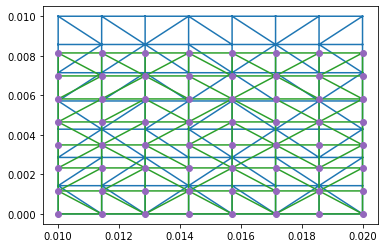

In [26]:
plt.triplot(areaPoints_Coords[:,0], areaPoints_Coords[:,1], tri.simplices.copy())
plt.triplot(u[:, 0] * coef_u + areaPoints_Coords[:, 0], u[:,1] * coef_u + areaPoints_Coords[:, 1], tri.simplices.copy())
plt.plot(areaPoints_Coords[:,0] + u[:, 0] * coef_u, areaPoints_Coords[:,1] + u[:, 1] * coef_u, 'o')
plt.show()

In [27]:
Eps=[]
for element in tri.simplices:
    B, A = CalculateStiffnessMatrix(element, areaPoints_Coords)
    Eps.append(np.dot(B, np.ravel(np.array([u[element[0]], u[element[1]], u[element[2]]])).transpose()))
Sigma = np.dot(D, np.array(Eps).transpose())
print("Sigma_xx ({:g} {:g})".format(min(Sigma.transpose()[:, 0]), max(Sigma.transpose()[:, 0])))
print("Sigma_yy ({:g} {:g})".format(min(Sigma.transpose()[:, 1]), max(Sigma.transpose()[:, 1])))
print("Sigma_xy ({:g} {:g})".format(min(Sigma.transpose()[:, 2]), max(Sigma.transpose()[:, 2])))
print(Sigma.transpose())

Sigma_xx (-1.03031e+07 -1.0303e+07)
Sigma_yy (-2.00001e+07 -1.99999e+07)
Sigma_xy (-53.7033 36.4759)
[[-1.03030137e+07 -1.99999943e+07  7.12994514e+00]
 [-1.03030342e+07 -2.00000007e+07  4.96940643e+00]
 [-1.03030309e+07 -1.99999995e+07  2.85139510e-01]
 [-1.03030344e+07 -2.00000000e+07  6.02862188e-01]
 [-1.03029655e+07 -1.99999172e+07  3.64759447e+01]
 [-1.03030598e+07 -1.99999932e+07  2.28518610e+01]
 [-1.03030105e+07 -1.99999484e+07 -1.27551461e+01]
 [-1.03030607e+07 -1.99999949e+07 -5.02085261e+00]
 [-1.03030427e+07 -2.00000018e+07  3.16690021e+00]
 [-1.03030241e+07 -1.99999883e+07  5.73967708e+00]
 [-1.03030222e+07 -1.99999888e+07 -7.60041364e+00]
 [-1.03030433e+07 -2.00000029e+07 -4.78588174e+00]
 [-1.03030292e+07 -1.99999982e+07 -1.05345958e+00]
 [-1.03030467e+07 -1.99999877e+07 -1.61798462e+00]
 [-1.03030459e+07 -1.99999860e+07  2.62547290e+01]
 [-1.03029900e+07 -1.99999986e+07  2.27933819e+01]
 [-1.03030064e+07 -2.00000070e+07  1.00093181e+01]
 [-1.03030393e+07 -2.00000075e+0

In [32]:
from itertools import groupby

relation_PointsElements = {}
boundPoints = []
subdElements = []
subdPoints = []
subdPoints_Coords = []
subdInternalPoints = []
subdBoundary = []

subdBounds = [bounds[0][0]] + [bounds[0][0] + i*(bounds[1][0] - bounds[0][0])/amntSubdomains[0] for i in range(1, amntSubdomains[0])] + [bounds[1][0]]
overlapBounds = [subdBounds[0]] + sum([[subdBounds[x] - (subdBounds[x] - subdBounds[x - 1]) * coefOverlap, subdBounds[x] + (subdBounds[x] - subdBounds[x - 1]) * coefOverlap]   
               for x in range(1, len(subdBounds)-1)], []) + [subdBounds[-1]]

subdElements.append([element.tolist() for element in tri.simplices 
                         if overlapBounds[0] < sum([areaPoints_Coords[element[i], 0] for i in range(3)])/3 < overlapBounds[2]])
for i in range(1, len(overlapBounds) - 3, 2):
    subdElements.append([element.tolist() for element in tri.simplices 
                         if overlapBounds[i] < sum([areaPoints_Coords[element[i], 0] for i in range(3)])/3 < overlapBounds[i+3]])
subdElements.append([element.tolist() for element in tri.simplices 
                         if overlapBounds[-3] < sum([areaPoints_Coords[element[i], 0] for i in range(3)])/3 < overlapBounds[-1]])

for subd in subdElements:
    subdPoints.append([el for el, _ in groupby(sorted(sum([i for i in subd], [])))])

for subd in subdPoints:
    subdPoints_Coords.append(np.array([areaPoints_Coords[i].tolist() for i in subd]))

for idx, val in enumerate(areaPoints_Coords):
    relation_PointsElements[idx] = [element.tolist() for element in tri.simplices if idx in element.tolist()]
    
for idv, subd in enumerate(subdElements):
    tempList = []
    relation_PointsElements_subd = {}
    for point in subdPoints[idv]:
        relation_PointsElements_subd[point] = [element for element in subd if point in element]
    for idx, val in relation_PointsElements_subd.items():
        if val != relation_PointsElements[idx]:
            tempList.append(idx)
    #for point in areaBoundaryPoints:
    #    if point in subdPoints[idv]:
    #        tempList.append(point)
    subdBoundary.append(list(set(tempList)))

for idx, subd in enumerate(subdElements):   
    subdInternalPoints.append(list(set(subdPoints[idx]) - set(subdBoundary[idx])))

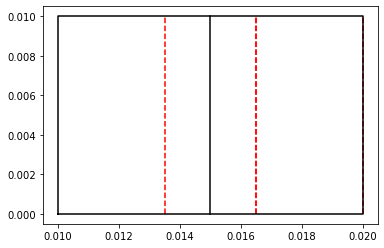

In [33]:
for i in range(1, len(subdBounds[1:])):
    plt.plot([subdBounds[i], subdBounds[i]], [bounds[0, 1], bounds[2, 1]], "k")
for i in range(1, len(overlapBounds) - 1):
    plt.plot([overlapBounds[i], overlapBounds[i]], [bounds[0, 1], bounds[2, 1]], "r--")
    plt.plot([overlapBounds[i+1], overlapBounds[i+1]], [bounds[0, 1], bounds[2, 1]], "r--")
plt.plot(bounds[:,0], bounds[:, 1], 'k')
plt.show()

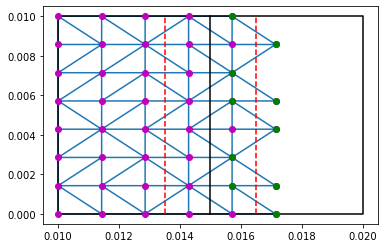

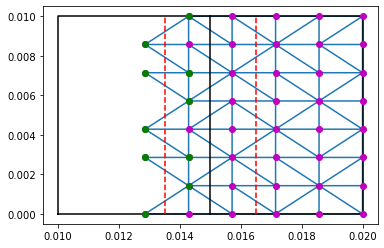

In [34]:
plt.triplot(areaPoints_Coords[:, 0], areaPoints_Coords[:, 1], subdElements[0])
plt.plot(bounds[:,0], bounds[:, 1], "k")
plt.plot(areaPoints_Coords[subdPoints[0]][:, 0], areaPoints_Coords[subdPoints[0]][:, 1], "om")
plt.plot([subdBounds[1], subdBounds[1]], [bounds[0, 1], bounds[2, 1]], "k")
plt.plot([overlapBounds[1], overlapBounds[1]], [bounds[0, 1], bounds[2, 1]], "r--")
plt.plot([overlapBounds[2], overlapBounds[2]], [bounds[0, 1], bounds[2, 1]], "r--")
plt.plot(areaPoints_Coords[subdBoundary[0], 0], areaPoints_Coords[subdBoundary[0], 1], 'og')
plt.show()

for i in range(1, len(subdElements) - 1):
    plt.triplot(areaPoints_Coords[:, 0], areaPoints_Coords[:, 1], subdElements[i])
    plt.plot(bounds[:,0], bounds[:, 1], "k")
    plt.plot(areaPoints_Coords[subdPoints[i]][:, 0], areaPoints_Coords[subdPoints[i]][:, 1], "om")
    plt.plot([subdBounds[i], subdBounds[i]], [bounds[0, 1], bounds[2, 1]], "k")
    plt.plot([subdBounds[i + 1], subdBounds[i + 1]], [bounds[0, 1], bounds[2, 1]], "k")
    plt.plot([overlapBounds[i * 2 - 1], overlapBounds[i * 2 - 1]], [bounds[0, 1], bounds[2, 1]], "r--")
    plt.plot([overlapBounds[i * 2], overlapBounds[i * 2]], [bounds[0, 1], bounds[2, 1]], "r--")
    plt.plot([overlapBounds[i * 2 + 1], overlapBounds[i * 2 + 1]], [bounds[0, 1], bounds[2, 1]], "r--")
    plt.plot([overlapBounds[i * 2 + 2], overlapBounds[i * 2 + 2]], [bounds[0, 1], bounds[2, 1]], "r--")
    plt.plot(areaPoints_Coords[subdBoundary[i], 0], areaPoints_Coords[subdBoundary[i], 1], 'og')
    plt.show()
    
plt.triplot(areaPoints_Coords[:, 0], areaPoints_Coords[:, 1], subdElements[-1])
plt.plot(bounds[:,0], bounds[:, 1], "k")
plt.plot(areaPoints_Coords[subdPoints[-1]][:, 0], areaPoints_Coords[subdPoints[-1]][:, 1], "om")
plt.plot([subdBounds[-2], subdBounds[-2]], [bounds[0, 1], bounds[2, 1]], "k")
plt.plot([overlapBounds[-3], overlapBounds[-3]], [bounds[0, 1], bounds[2, 1]], "r--")
plt.plot([overlapBounds[-2], overlapBounds[-2]], [bounds[0, 1], bounds[2, 1]], "r--")
plt.plot(areaPoints_Coords[subdBoundary[-1], 0], areaPoints_Coords[subdBoundary[-1], 1], 'og')
plt.show()

[33, 34, 36, 37, 39, 40, 41, 43, 44, 46]


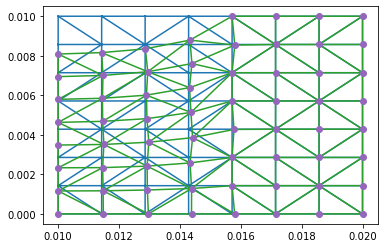

[16, 18, 19, 21, 22, 25, 26, 28, 29, 31]


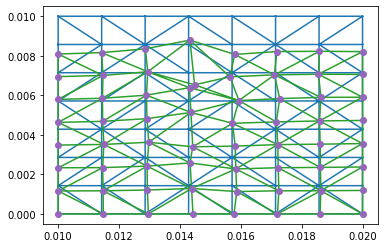

[33, 34, 36, 37, 39, 40, 41, 43, 44, 46]


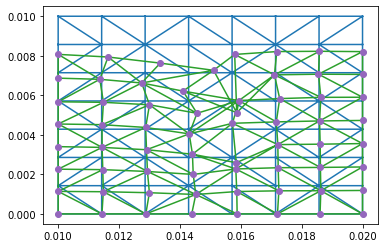

[16, 18, 19, 21, 22, 25, 26, 28, 29, 31]


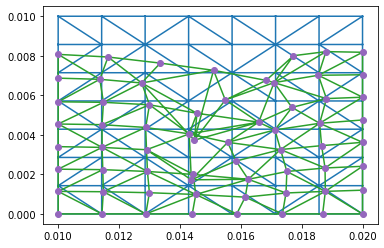

[33, 34, 36, 37, 39, 40, 41, 43, 44, 46]


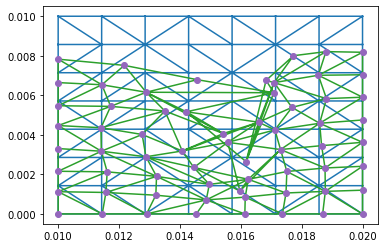

[16, 18, 19, 21, 22, 25, 26, 28, 29, 31]


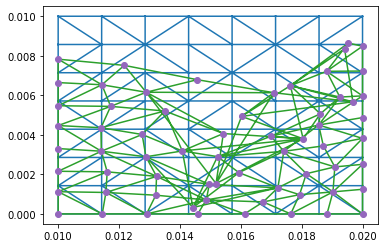

[33, 34, 36, 37, 39, 40, 41, 43, 44, 46]


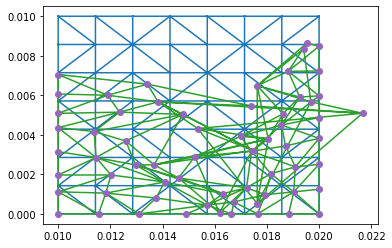

[16, 18, 19, 21, 22, 25, 26, 28, 29, 31]


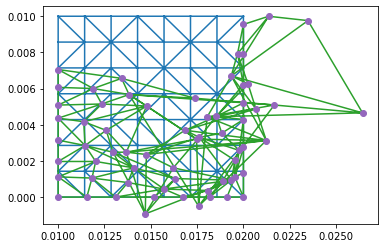

[33, 34, 36, 37, 39, 40, 41, 43, 44, 46]


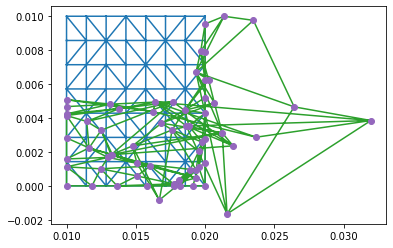

[16, 18, 19, 21, 22, 25, 26, 28, 29, 31]


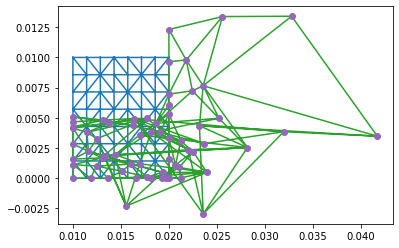

In [35]:
it = 0
u_global = np.zeros((areaPoints_Coords.shape[0], 2))
D = np.array([[1, nyu/(1-nyu), 0], [nyu/(1-nyu), 1, 0], [0, 0, (1-2 * nyu) / 2 / (1-nyu)]]) * E * (1-nyu) / (1-2 * nyu) / (1+nyu)
while True:
    u_Previous = np.copy(u_global)
    for idv, subd in enumerate(subdElements):
        
        ratioPoints_LocalGlobal = dict(zip(range(len(subdPoints[idv])), subdPoints[idv]))
        ratioPoints_GlobalLocal = {v: k for k, v in ratioPoints_LocalGlobal.items()}
        
        K_global = np.zeros((len(ratioPoints_GlobalLocal) * 2, len(ratioPoints_GlobalLocal) * 2))
        F = np.zeros((len(ratioPoints_GlobalLocal) * 2, 1))
        subdElements_Local = np.array([ratioPoints_GlobalLocal[x] for x in np.array(subd).ravel()]).reshape(len(subd), 3)

        for element in subdElements_Local:
            B, A = CalculateStiffnessMatrix(element, subdPoints_Coords[idv])
            K = np.dot(np.dot(B.transpose(), D), B) * A
            for i in range(3):
                for j in range(3):
                    K_global[element[i]*dimTask:element[i]*dimTask+2, element[j]*dimTask:element[j]*dimTask+2] += K[i*dimTask:i*dimTask+2,j*dimTask:j*dimTask+2]

        for condition in dirichletPoints:
            listPoints = list(set(condition[0]) & set(subdPoints[idv]))
            for node in listPoints:
                K_global, F = boundCondition_Dirichlet(K_global, F, dimTask, ratioPoints_GlobalLocal[node], 0, condition[1])
        
        for condition in neumannPoints:
            listPoints = list(set(condition[0]) & set(subdPoints[idv]))
            segmentPoints = list(combinations(listPoints, 2))
            for element in [element for element in subd for x in segmentPoints if x[0] in element and x[1] in element]:                
                F = boundCondition_Neumann(F, [ratioPoints_GlobalLocal[x] for x in element], [ratioPoints_GlobalLocal[x] for x in listPoints], dimTask, condition[1], subdPoints_Coords[idv], 0)
                F = boundCondition_Neumann(F, [ratioPoints_GlobalLocal[x] for x in element], [ratioPoints_GlobalLocal[x] for x in listPoints], dimTask, condition[2], subdPoints_Coords[idv], 1)
        
        listPoints_Schwarz = sum([list(set(subdBoundary[idv]) & set(subd)) for idx, subd in enumerate(subdInternalPoints) if idx != idv], [])
        print(listPoints_Schwarz)
        for node in listPoints_Schwarz:
            K_global, F = boundCondition_Dirichlet(K_global, F, dimTask, ratioPoints_GlobalLocal[node], u_global[node, 0], dim = 0)
            K_global, F = boundCondition_Dirichlet(K_global, F, dimTask, ratioPoints_GlobalLocal[node], u_global[node, 1], dim = 1)
              
        u_local = np.linalg.solve(K_global, F).reshape((subdPoints_Coords[idv].shape[0], 2))     
        
        for x in list(ratioPoints_LocalGlobal.keys()):
            u_global[ratioPoints_LocalGlobal[x], :] = u_local[x, :]

        plt.triplot(areaPoints_Coords[:,0], areaPoints_Coords[:,1], tri.simplices.copy())
        plt.triplot(u_global[:, 0] * coef_u + areaPoints_Coords[:, 0], u_global[:,1] * coef_u + areaPoints_Coords[:, 1], tri.simplices.copy())
        plt.plot(areaPoints_Coords[:,0] + u_global[:, 0] * coef_u, areaPoints_Coords[:,1] + u_global[:, 1] * coef_u, 'o')
        plt.show()
    it += 1
    if it == 5:
        break

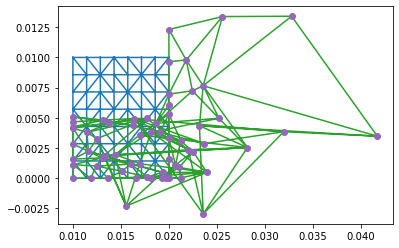

In [36]:
plt.triplot(areaPoints_Coords[:,0], areaPoints_Coords[:,1], tri.simplices.copy())
plt.triplot(u_global[:, 0] * coef_u + areaPoints_Coords[:, 0], u_global[:,1] * coef_u + areaPoints_Coords[:, 1], tri.simplices.copy())
plt.plot(areaPoints_Coords[:,0] + u_global[:, 0] * coef_u, areaPoints_Coords[:,1] + u_global[:, 1] * coef_u, 'o')
plt.show()

In [13]:
Eps=[]
for element in tri.simplices:
    B, A = CalculateStiffnessMatrix(element, areaPoints_Coords)
    Eps.append(np.dot(B, np.ravel(np.array([u_global[element[0]], u_global[element[1]], u_global[element[2]]])).transpose()))
Eps=np.array(Eps)
Sigma=np.dot(D, Eps.transpose())
print("Sigma_xx ({:g} {:g})".format(min(Sigma.transpose()[:, 0]), max(Sigma.transpose()[:, 0])))
print("Sigma_yy ({:g} {:g})".format(min(Sigma.transpose()[:, 1]), max(Sigma.transpose()[:, 1])))
print("Sigma_xy ({:g} {:g})".format(min(Sigma.transpose()[:, 2]), max(Sigma.transpose()[:, 2])))
print(Sigma.transpose())

Sigma_xx (-2.34513e+08 1.47729e+08)
Sigma_yy (-1.85404e+08 6.6534e+07)
Sigma_xy (-3.2874e+07 5.27448e+07)
[[ 7.91894444e+06 -3.37665489e+07  1.42026349e+07]
 [-1.10973817e+07 -4.99731372e+07  1.13848018e+07]
 [-6.63692536e+07 -3.76916287e+07 -2.93009869e+06]
 [-5.32085927e+07 -3.43418766e+07 -4.25093173e+06]
 [ 1.74238565e+07 -1.84189318e+07 -2.42958989e+06]
 [ 1.77302010e+07 -1.47211685e+07 -2.74991851e+06]
 [-4.87404718e+07 -3.20401174e+07  6.58109347e+06]
 [-7.64550008e+07 -6.32408179e+07  1.86787511e+06]
 [ 3.09605814e+07 -4.43888109e+07  1.15503163e+07]
 [ 1.18003030e+08 -1.89530390e+07  2.55205863e+06]
 [ 4.52133266e+07 -1.95582636e+07 -3.01019519e+06]
 [ 1.16688333e+08 -2.15050976e+07  2.55205863e+06]
 [-3.18348493e+07 -3.76070226e+07  2.74319775e-08]
 [-6.63325578e+07 -3.76203956e+07  2.76088652e+06]
 [-2.47711669e+07 -5.06069093e+07  1.31449356e+07]
 [-6.21454122e+07 -3.54633812e+07  1.13664782e+07]
 [ 1.86426073e+07 -3.46525369e+07  8.46960256e+06]
 [-4.53970248e+07 -4.997477